In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import scipy 
import h5py

DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

/home/users/yucli/sicpred_env/lib64/python3.6/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'siconc' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/home/users/yucli/sicpred_env/lib64/python3.6/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'nsidc_bt_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/home/users/yucli/sicpred_env/lib64/python3.6/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'nsidc_nt_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/home/users/yucli/sicpred_env/lib64/python3.6/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'qa_of_cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_

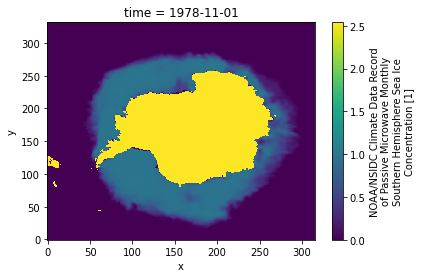

In [5]:
nsidc_sic = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc")
nsidc_sic.siconc.isel(time=0).plot()

### Inputs/outputs

In [2]:
# params for problem definition 

# how many months into the future to predict 
max_month_lead_time = 6 

# input variable params  
input_config = {
    'siconc': {
        'plevel': None,
        'short_name': 'siconc',
        'include': True,
        'anom': False,
        'land_mask': True,
        'lag': 12
    },
    'siconc_linear_forecast': {
        'plevel': None,
        'short_name': 'siconc',
        'include': False,
        'anom': False,
        'land_mask': True,
        'lag': None
    },
    '10m_u_component_of_wind': {
        'plevel': None,
        'short_name': 'u10',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 1
    }, 
    '10m_v_component_of_wind': {
        'plevel': None,
        'short_name': 'v10',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 1
    }, 
    '2m_temperature': {
        'plevel': None,
        'short_name': 't2m',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    'mean_sea_level_pressure': {
        'plevel': None,
        'short_name': 'msl',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    'sea_surface_temperature': {
        'plevel': None,
        'short_name': 'sst',
        'include': False,
        'anom': True,
        'land_mask': True,
        'lag': 9
    }, 
    'surface_net_solar_radiation': {
        'plevel': None,
        'short_name': 'ssr',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    'surface_net_thermal_radiation': {
        'plevel': None,
        'short_name': 'str',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    'geopotential': {
        'plevel': '500',
        'short_name': 'z',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 3
    },
    'cosine_of_init_month': {
        'include': True,
        'land_mask': False
    },
    'sine_of_init_month': {
        'include': True,
        'land_mask': False
    }
}

# Note missing data for 1987 Dec and 1988 Jan. So remove those from the prediction months
first_range = pd.date_range('1981-01', pd.Timestamp('1987-12') - pd.DateOffset(months=max_month_lead_time+1), freq='MS')
second_range = pd.date_range(pd.Timestamp('1988-01') + pd.DateOffset(months=input_config['siconc']['lag']+1), '2024-01', freq='MS')

start_prediction_months = first_range.append(second_range)


In [16]:
def write_hdf5_file(data, save_path, dataset_name, verbose=1):
    """
    Saves hdf5 file to save_path. 

    Params:
        data:           numpy ndarray 
        save_path:      (str) valid file path ending in .h5
        dataset_name:   (str) name of dataset 
    """

    with h5py.File(save_path, 'w') as f:
        f.create_dataset(dataset_name, data=data)

    if verbose == 2: print(f'Saved to {save_path}')

# Define land mask using both SST and sea ice 
sst = xr.open_dataset(f"{DATA_DIRECTORY}/ERA5/sea_surface_temperature_SPS.nc").sst
land_mask_from_sst = np.isnan(sst.isel(time=0)).values

nsidc_sic = xr.open_dataset(f'{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc')
land_mask_from_sic = np.logical_or(nsidc_sic.siconc.isel(time=0) == 2.53, nsidc_sic.siconc.isel(time=0) == 2.54)

land_mask = np.logical_or(land_mask_from_sst, land_mask_from_sic).data
land_mask = land_mask[np.newaxis, :, :]

data_da_dict = {}

for input_var, input_var_params in input_config.items():
    if input_var == 'siconc':
        data_da_dict[input_var] = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc").siconc

    elif input_var == 'siconc_linear_forecast':
        if input_var_params['anom']: 
            print("Have not calculated anomaly linear forecast. Defaulting to non-normalized values")
        data_da_dict[input_var] = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/linear_forecasts/linear_forecast_all_years.nc").siconc
    
    elif input_var in ['cosine_of_init_month', 'sine_of_init_month']:
        continue 

    else:
        if input_var_params['anom']:
            data_da_dict[input_var] = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/normalized_inputs/{input_var}_norm.nc")[input_var_params['short_name']]
        else:
            data_da_dict[input_var] = xr.open_dataset(f"{DATA_DIRECTORY}/ERA5/{input_var}_SPS.nc")[input_var_params['short_name']]
        
all_outputs = []

for start_prediction_month in start_prediction_months:
    prediction_target_months = pd.date_range(start_prediction_month, \
        start_prediction_month + pd.DateOffset(months=max_month_lead_time-1), freq="MS")
        
    target_npy = data_da_dict["siconc"].sel(time=prediction_target_months).data
    land_mask_broadcast = np.repeat(land_mask, max_month_lead_time, axis=0)
    target_npy[land_mask_broadcast] = 0
    target_npy = target_npy[np.newaxis,:,:,:]

    all_outputs.append(target_npy)

all_outputs = np.concatenate(all_outputs, axis=0)

save_directory = os.path.join(DATA_DIRECTORY, "sicpred/data_pairs_npy")
outputs_save_path = os.path.join(save_directory, f"targets.h5")

write_hdf5_file(all_outputs, outputs_save_path, f"targets_sea_ice_only")

/home/users/yucli/sicpred_env/lib64/python3.6/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'siconc' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/home/users/yucli/sicpred_env/lib64/python3.6/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'nsidc_bt_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/home/users/yucli/sicpred_env/lib64/python3.6/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'nsidc_nt_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/home/users/yucli/sicpred_env/lib64/python3.6/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'qa_of_cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_

In [2]:
def read_hdf5_file(data_path, data_name, load=True):
    with h5py.File(data_path, 'r') as f:
        return f[data_name][()]

In [ ]:
read_hdf5_file(f"{DATA_DIRECTORY}/sicpred/data_pairs_npy/inputs_simple.h5", "inputs_simple")

### Notes from previous experimentation

7/17 SST below sea ice has very very small standard deviations ($\sigma \sim \mathcal{O}(0.0001)$) since it is in equilibrium with the sea ice. So $(x - \mu)/\sigma$ is a small number over a small number. Normalized values don't really make too much physical sense.

One option is to set a threshold minimum bound for $x - \mu$ for SST only, and set the normalized value to 0 (since we expect SST under sea ice to be $\approx T_f$)

Edit:
7/18: set threshold value for $\sigma$. See util.py